# ARIMA Forecasting Demonstration

This notebook forecasts AWS EC2 spot prices using ARIMA. Parameters are identified both manually and through a grid search, after which these two parameter-generating methods are compared.

Beyond ARIMA, this code demonstrates multiprocess computing (for the ARIMA parameter grid search) and object-oriented programming in the "prepare_data" module.

## Reduce the listing of warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Load useful system modules

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from multiprocessing import Pool

## Specify user settings

Ideally this would be loaded from a configuration file:

In [4]:
proportion_of_timestamps_to_train_model_with = 0.9
n_grid_search_p_d_q = 6
#use_previously_saved_set = True
#save_filename = 'output/df_ec2_spot_prices.csv'
time_series_frequency = 'D'

input_pickle_file = '/home/emily/Desktop/projects/bds/forecasting/ARIMA/output/ec2_spot_price__1734706310.105263.pickle'

## Get data

We either pull spot price data from the AWS EC2 API or we load previously saved data

In [5]:
with open(input_pickle_file, 'rb') as f:
    instance = pickle.load(f)

df = instance.df

## Visually inspect the data

In [6]:
df

,spot_price
Timestamp,
2024-09-21 00:00:00+00:00,0.071400
2024-09-22 00:00:00+00:00,0.072000
2024-09-23 00:00:00+00:00,0.072300
2024-09-24 00:00:00+00:00,0.072267
2024-09-25 00:00:00+00:00,0.073000
...,...
2024-12-16 00:00:00+00:00,0.066300
2024-12-17 00:00:00+00:00,0.066150
2024-12-18 00:00:00+00:00,0.066075


## Divide into training and test sets

For time series work, it is important that the test set chronologically follows the training set:

In [7]:
n_train = np.int32(np.round(proportion_of_timestamps_to_train_model_with * len(df.index)))
n_test = np.int32(np.round((1. - proportion_of_timestamps_to_train_model_with) * len(df.index)))

In [8]:
df_train = df.iloc[0:n_train, :]
df_test = df.iloc[n_train:, :]

# QA
print(len(df_train.index) + len(df_test.index))

91


## Plot the time series we plan to model

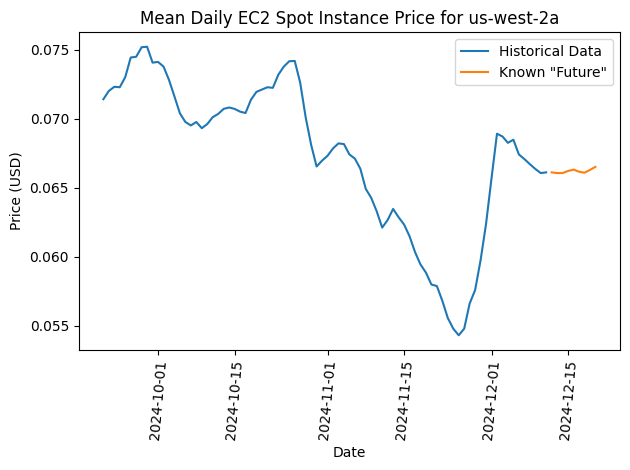

In [10]:
plt.figure()
plt.plot(df_train.index, df_train['spot_price'], label = 'Historical Data')
plt.plot(df_test.index, df_test['spot_price'], label = 'Known "Future"')
plt.title('Mean Daily EC2 Spot Instance Price for ' + instance.config['availability_zone'])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation = 85)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## Plot the ACF and PACF of the training data

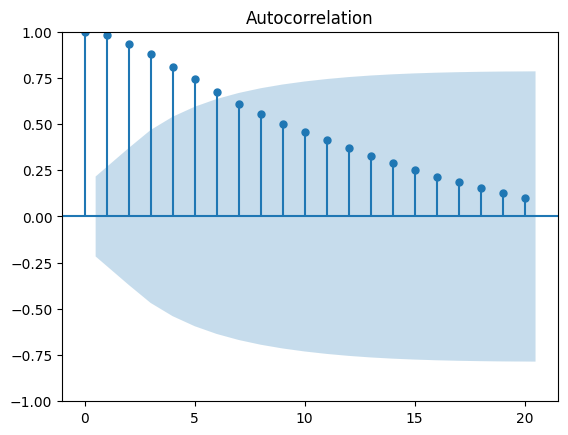

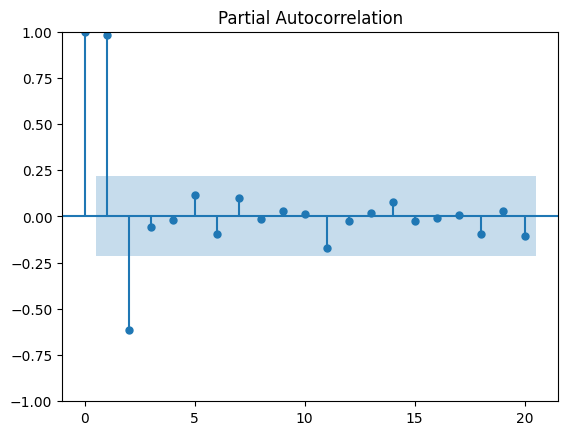

In [11]:
plot_acf(df_train['spot_price'])
plt.show()
plt.close()

plot_pacf(df_train['spot_price'])
plt.show()
plt.close()

# Visually inspect the ACF and PACF to estimate p and q values for the forthcoming ARIMA

In [12]:
p_visual = 5  # This is the count of lags on the ACF between lag zero and the first lag having a correlation value within the shaded area, exclusive.
q_visual = 1  # This is the count of lags on the PACF between lag zero and the first lag having a correlation value within the shaded area, exclusive.

# Difference the training time series to select a value for ARIMA parameter "d"

This starts with d = 0 and iterates a differencing loop to find the first value of d that produces a Augmented Dickey–Fuller test having a p-value less or equal to 0.5:

In [13]:
# https://machinelearningmastery.com/time-series-data-stationary-python/

p_value = 1.
d_iterative_search = -1

while p_value > 0.05:

    d_iterative_search += 1
    
    if d_iterative_search == 0:
        series_train_diff = df_train['spot_price'] - 0.
    else:
        series_train_diff = df_train['spot_price'] - df_train['spot_price'].shift(-1 * d_iterative_search)

    result = adfuller(series_train_diff.dropna())

    print('d = %i' % d_iterative_search)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))

    p_value = result[1]
    print()

print('Final differencing term: d = %i' % d_iterative_search)

d = 0
ADF Statistic: -2.094142
p-value: 0.246877
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586

d = 1
ADF Statistic: -3.426973
p-value: 0.010073
Critical Values:
	1%: -3.519
	5%: -2.900
	10%: -2.587

Final differencing term: d = 1


# Define a plotting function for reuse

Given training data, testing data, an ARIMA model fit, this function plots known and forecast results:

In [14]:
def plot_it_all(
    df_train,
    df_test,
    fit,
    column_name = 'spot_price',
    label_historical = 'Historical Values',
    label_model_of_historical = 'ARIMA Fit on Historical Values',
    label_known_future = 'Known Future',
    label_forecast_future = 'Forecast Future',   
):

    y_fit = fit.predict()
    y_predicted = fit.forecast(steps = len(df_test.index))

    full_index_as_date_list = [x.date for x in df_train.index]
    full_index_as_date_list.extend([x.date for x in df_test.index])

    plt.figure()
    plt.plot(df_train.index, df_train[column_name], label = label_historical)
    plt.plot(df_train.index[2:], y_fit[2:], label = label_model_of_historical)
    plt.plot(df_test.index, df_test[column_name], label = label_known_future)
    plt.plot(df_test.index, y_predicted, label = label_forecast_future)
    plt.xticks(rotation = 85)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

## Build an ARIMA model using the parameters derived from visual inspection (p and q) and from the differencing operation (d) 

...and plot it:

/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


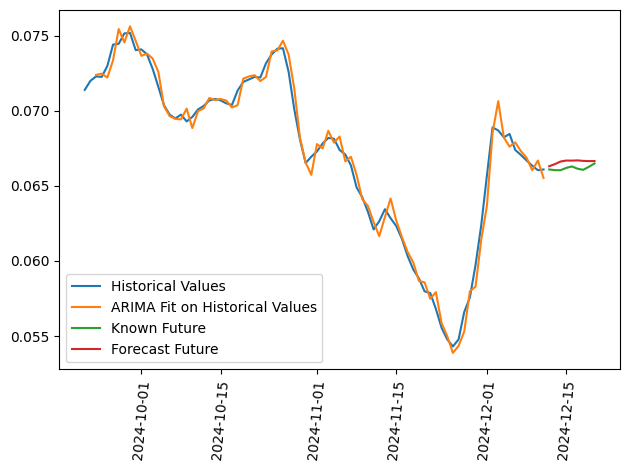

In [15]:
model = ARIMA(df_train['spot_price'], freq = time_series_frequency, order = (p_visual, d_iterative_search, q_visual))
fit = model.fit()
plot_it_all(df_train, df_test, fit)

## Build an ARIMA model using an automated search for the best parameters

We use a grid search to find the ARIMA parameters than minimize the MSE. A hill-climbing algorithm would be more elegant, but because we farm the calculations out to multiple processes, this procedure proves fast enough.

...and we plot it:

In [16]:
%%capture --no-stderr

order_list = product(
    list(
        range(0, n_grid_search_p_d_q)
    ), 
    list(
        range(0, n_grid_search_p_d_q)
    ),
    list(
        range(0, n_grid_search_p_d_q)
    )
)

def compute_ARIMA_model_for_a_given_order(order):

    try:
        model = ARIMA(df_train['spot_price'], freq = time_series_frequency, order = order)
        fit = model.fit()
        mse = mean_squared_error(df_train['spot_price'], fit.fittedvalues)
    except np.linalg.LinAlgError as e:
        mse = None
   
    return mse, order

with Pool(5) as pool:
    results = pool.map(compute_ARIMA_model_for_a_given_order, list(order_list))

mse_dict = {}
for mse, order in results:
    mse_f = float(mse)
    if not mse_f in mse_dict:
        mse_dict[mse_f] = []
    mse_dict[mse_f].append(order)

min_mse = min(mse_dict.keys())

best_order = mse_dict[min_mse][0]

/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model

(5, 0, 2)


/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


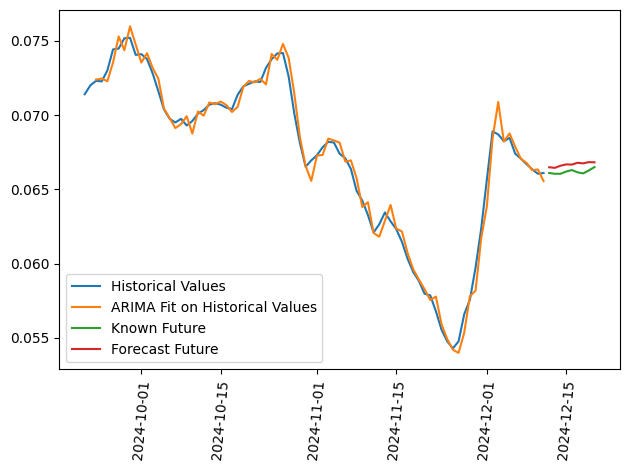

In [17]:
print(best_order)

model_best = ARIMA(df_train['spot_price'], freq = time_series_frequency, order = best_order)
fit_best = model_best.fit()
plot_it_all(df_train, df_test, fit_best)

## Compare the models

We compare the model based on visually selected parameters to the model based on automatically selected "best" parameters.

The fit generated using the grid search-identified parameters has a lower AIC than the fit generated from visual inspection. By contrast, the fit generated from visual inspection has a lower BIC than the fit using the grid search-identified parameters. So I conclude that both sets of parameters are defendible.

In [18]:
print(fit.aic, fit_best.aic)
print(fit.bic, fit_best.bic)

-936.2945056830373 -941.6581485310297
-919.5333616003302 -919.9976753056515


In [19]:
def plot_it_all_compare(
    df_train,
    df_test,
    fit,
    fit_best,
    column_name = 'spot_price',
    label_historical = 'Historical Values',
    label_model_of_historical = 'ARIMA Fit on Historical Values',
    label_known_future = 'Known Future',
    label_forecast_future = 'Forecast Future',
    label_best_forecast_future = 'Best Forecast Future',
):

    y_fit = fit.predict()
    y_predicted = fit.forecast(steps = len(df_test.index))
    y_fit_best = fit_best.predict()
    y_best_predicted = fit_best.forecast(steps = len(df_test.index))

    full_index_as_date_list = [x.date for x in df_train.index]
    full_index_as_date_list.extend([x.date for x in df_test.index])

    plt.figure()
    plt.plot(df_train.index, df_train[column_name], label = label_historical)
    plt.plot(df_train.index[2:], y_fit[2:], label = label_model_of_historical)
    plt.plot(df_test.index, df_test[column_name], label = label_known_future)
    plt.plot(df_test.index, y_predicted, label = label_forecast_future)
    plt.plot(df_test.index, y_best_predicted, label = label_best_forecast_future)
    plt.xticks(rotation = 85)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

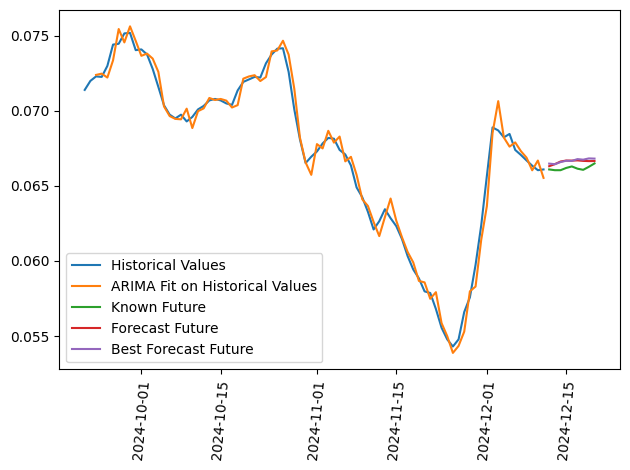

In [20]:
plot_it_all_compare(df_train, df_test, fit, fit_best)